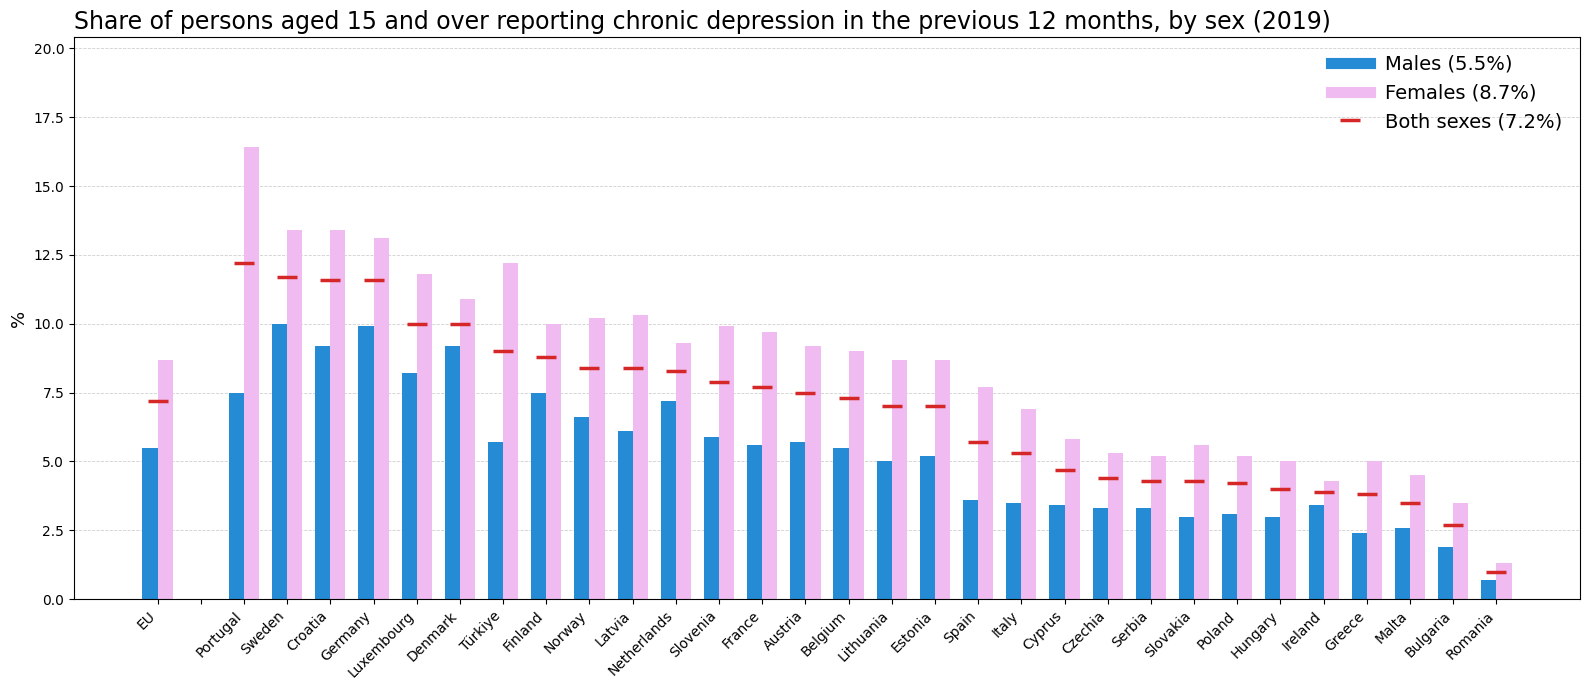

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Carico il file
path = "Dataset\chronic-depression-eu-sex.csv"
df = pd.read_csv(path)

# Seleziono i tre blocchi
df_f = df[df['sex'].str.lower().str.contains('female')][['geo','OBS_VALUE']].rename(columns={'OBS_VALUE':'Females'})
df_m = df[df['sex'].str.lower().str.contains('male') & ~df['sex'].str.lower().str.contains('female')][['geo','OBS_VALUE']].rename(columns={'OBS_VALUE':'Males'})
df_t = df[df['sex'].str.lower().str.contains('total')][['geo','OBS_VALUE']].rename(columns={'OBS_VALUE':'Total'})

# Merge per geo
df_joined = df_f.merge(df_m, on='geo', how='inner').merge(df_t, on='geo', how='inner')
df_joined = df_joined.rename(columns={'geo':'Country'})

# Converti valori numerici
for c in ['Females','Males','Total']:
    df_joined[c] = pd.to_numeric(df_joined[c], errors='coerce')

# Converto in EU
df_eu = df_joined[df_joined['Country'].str.contains("European Union", case=False)].copy()
df_eu['Country'] = "EU"

df_rest = df_joined[~df_joined['Country'].str.contains("European Union", case=False)].copy()
df_rest = df_rest.sort_values('Total', ascending=False)

# Inserisco EU come prima riga
df_plot = pd.concat([df_eu, df_rest], ignore_index=True)

# Per separare graficamente EU dagli altri aggiungo uno spazio vuoto
df_plot.loc[1] = ["", np.nan, np.nan, np.nan]  
df_plot = df_plot.reset_index(drop=True)

eu_row = df_plot[df_plot['Country'] == "EU"].iloc[0]

males_eu = eu_row['Males']
females_eu = eu_row['Females']
total_eu = eu_row['Total']

# Plot 
countries = df_plot['Country'].tolist()
x = np.arange(len(countries))
width = 0.35

fig, ax = plt.subplots(figsize=(16,7))

# Disegna barre solo per righe non vuote
mask = df_plot['Country'] != ""
ax.bar(x[mask] - width/2, df_plot.loc[mask,'Males'], width, label='Males', color="#248bd4")
ax.bar(x[mask] + width/2, df_plot.loc[mask,'Females'], width, label='Females', color="#efbbf0")

# Both sexes come trattino
ax.plot(x[mask], df_plot.loc[mask,'Total'], linestyle='None', marker='_', 
        markersize=14, markeredgewidth=2.5, color='#d62728')

# Griglia e labels
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
ax.set_title("Share of persons aged 15 and over reporting chronic depression in the previous 12 months, by sex (2019)",
             fontsize=17, loc='left')
ax.set_ylabel('%', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(countries, rotation=45, ha='right')
ax.set_ylim(0, max(df_plot['Total'].dropna().max(), 
                   df_plot['Females'].dropna().max(), 
                   df_plot['Males'].dropna().max()) + 4)


# Legenda-
legend_elems = [
    Line2D([0], [0], color="#248bd4", lw=8, label=f'Males ({males_eu:.1f}%)'),
    Line2D([0], [0], color="#efbbf0", lw=8, label=f'Females ({females_eu:.1f}%)'),
    Line2D([0], [0], color='#d62728', marker='_', markersize=14, markeredgewidth=2.5,
           linestyle='None', label=f'Both sexes ({total_eu:.1f}%)')
]

ax.legend(handles=legend_elems, loc='upper right', frameon=False, fontsize=14)

plt.tight_layout()
plt.show()
